In [ ]:
# imports and helper functions 
import os
import sys

# set project root 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import joblib
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2

#  helper Functions
from helpers.visualization_helpers import plot_confusion_matrix, print_classification_report

In [2]:
# load all preprocessed data

# 3 vectorizers
bow_vectorizer = joblib.load('../outputs/models/bow_vectorizer.joblib')
tfidf_vectorizer = joblib.load('../outputs/models/tfidf_vectorizer.joblib')
spacy_model = joblib.load('../outputs/models/spacy_model.joblib')

# Load in training data
X_train_tfidf = joblib.load('../outputs/models/X_train_tfidf_balanced.joblib')
X_train_bow = joblib.load('../outputs/models/X_train_bow_balanced.joblib')
X_train_spacy = joblib.load('../outputs/models/X_train_spacy_balanced.joblib')

y_train_tfidf = joblib.load('../outputs/models/y_train_tfidf_balanced.joblib')
y_train_bow = joblib.load('../outputs/models/y_train_bow_balanced.joblib')
y_train_spacy = joblib.load('../outputs/models/y_train_spacy_balanced.joblib')

print("Preprocessed data loaded successfully.")

Preprocessed data loaded successfully.


In [4]:
# Number of classes for 5 ratings
num_classes = 5

# Function to prepare data for NN
def prepare_nn_data(X, y):
    y_cat = to_categorical(y - 1, num_classes)  # move labels to start from 0
    if hasattr(X, 'toarray'):
        X = X.toarray()  # make into dense
    return X, y_cat

In [5]:
# use a pretty table to log everything and make clear 
class TrainingLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        table = PrettyTable()
        table.field_names = ["Epoch", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]
        table.add_row([
            epoch + 1,
            logs.get("loss"),
            logs.get("accuracy"),
            logs.get("val_loss"),
            logs.get("val_accuracy")
        ])
        print(table)

In [7]:
# Neural Network with TFIDF
X_nn_tfidf, y_nn_tfidf = prepare_nn_data(X_train_tfidf, y_train_tfidf)

nn_tfidf = Sequential([
    Input(shape=(X_nn_tfidf.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

nn_tfidf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_tfidf = nn_tfidf.fit(
    X_nn_tfidf, y_nn_tfidf, 
    validation_split=0.2,  # Using validation split for validation metrics
    epochs=5, 
    batch_size=32, 
    callbacks=[TrainingLogger()]
)
nn_tfidf.save('../outputs/models/Neural_Network_TFIDF.keras')

Epoch 1/5
903/906 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6229 - loss: 0.9123+-------+--------------------+--------------------+--------------------+---------------------+
| Epoch |   Training Loss    | Training Accuracy  |  Validation Loss   | Validation Accuracy |
+-------+--------------------+--------------------+--------------------+---------------------+
|   1   | 0.6570318937301636 | 0.7273919582366943 | 0.8138411641120911 |  0.6718210577964783 |
+-------+--------------------+--------------------+--------------------+---------------------+
906/906 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6233 - loss: 0.9112 - val_accuracy: 0.6718 - val_loss: 0.8138
Epoch 2/5
906/906 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8630 - loss: 0.3420+-------+---------------------+-------------------+--------------------+---------------------+
| Epoch |    Training Loss    | Training Accuracy |  Validation Loss   | Validation Accuracy |
+-------+---------------------+-------------------

In [12]:
# define the bow model
X_nn_bow, y_nn_bow = prepare_nn_data(X_train_bow, y_train_bow)

# added for BOW l2 regularization and a small dropout. Still severe overfitting
nn_bow = Sequential([
    Input(shape=(X_nn_bow.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(64,activation='relu'),
    Dense(num_classes, activation='softmax')
])


# compile
nn_bow.compile(optimizer=Adam(learning_rate=0.001), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# callback for early stopping pending validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train BOW + NN
history_bow = nn_bow.fit(
    X_nn_bow, y_nn_bow, 
    validation_split=0.2,  
    epochs=50,           
    batch_size=32,        
    callbacks=[TrainingLogger(), early_stopping]
)

# save to job lib files
nn_bow.save('../outputs/models/Neural_Network_BOW.keras')


Epoch 1/50
894/906 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5846 - loss: 1.0964+-------+-------------------+--------------------+-------------------+---------------------+
| Epoch |   Training Loss   | Training Accuracy  |  Validation Loss  | Validation Accuracy |
+-------+-------------------+--------------------+-------------------+---------------------+
|   1   | 0.949047327041626 | 0.6512494683265686 | 1.925663948059082 |  0.2398177534341812 |
+-------+-------------------+--------------------+-------------------+---------------------+
906/906 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5855 - loss: 1.0943 - val_accuracy: 0.2398 - val_loss: 1.9257
Epoch 2/50
900/906 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7450 - loss: 0.7759+-------+--------------------+--------------------+-------------------+---------------------+
| Epoch |   Training Loss    | Training Accuracy  |  Validation Loss  | Validation Accuracy |
+-------+--------------------+--------------------+---------

In [9]:
# Neural Network with spaCy
X_nn_spacy, y_nn_spacy = prepare_nn_data(X_train_spacy, y_train_spacy)

nn_spacy = Sequential([
    Input(shape=(X_nn_spacy.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(64,activation='relu'),
    Dense(num_classes, activation='softmax')
])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_spacy.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_spacy = nn_spacy.fit(
    X_nn_spacy, y_nn_spacy,
    validation_split=0.1, # made small
    epochs=200,  # Increased epochs 50-> 200
    batch_size=16,# 32 -> 64
    callbacks=[TrainingLogger(), early_stopping]
)

nn_spacy.save('../outputs/models/Neural_Network_SPACY.keras')

Epoch 1/200
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4604 - loss: 1.4287+-------+--------------------+--------------------+--------------------+---------------------+
| Epoch |   Training Loss    | Training Accuracy  |  Validation Loss   | Validation Accuracy |
+-------+--------------------+--------------------+--------------------+---------------------+
|   1   | 1.2885297536849976 | 0.5139753818511963 | 1.3173000812530518 | 0.44119271636009216 |
+-------+--------------------+--------------------+--------------------+---------------------+
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4604 - loss: 1.4286 - val_accuracy: 0.4412 - val_loss: 1.3173
Epoch 2/200
2037/2038 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5785 - loss: 1.1281+-------+--------------------+--------------------+--------------------+---------------------+
| Epoch |   Training Loss    | Training Accuracy  |  Validation Loss   | Validation Accuracy |
+-------+--------------------+----------

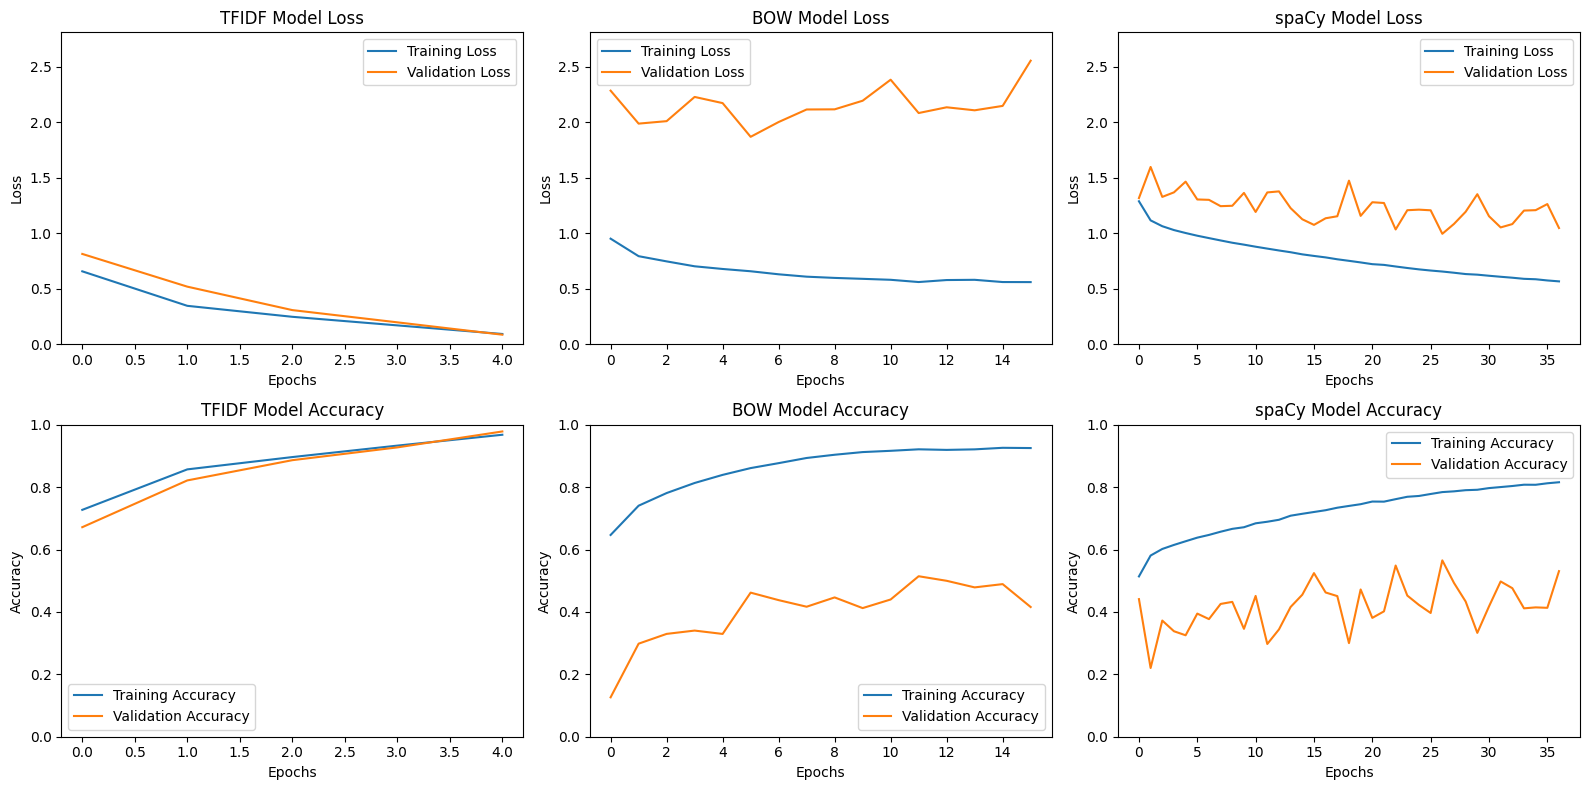

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# have all lims start at 0 so its clear to compare across the (2x3)
loss_ylim = (0, max(
    max(history_tfidf.history['loss'] + history_tfidf.history['val_loss']),
    max(history_bow.history['loss'] + history_bow.history['val_loss']),
    max(history_spacy.history['loss'] + history_spacy.history['val_loss'])
) * 1.1)  # add padding 

accuracy_ylim = (0, 1)  # (range is between 0-1)

# TFIDF model loss plot
axes[0, 0].plot(history_tfidf.history['loss'], label='Training Loss')
axes[0, 0].plot(history_tfidf.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('TFIDF Model Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_ylim(loss_ylim)  
axes[0, 0].legend()

# BOW model loss plot
axes[0, 1].plot(history_bow.history['loss'], label='Training Loss')
axes[0, 1].plot(history_bow.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('BOW Model Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_ylim(loss_ylim) 
axes[0, 1].legend()

# spaCy model loss plot
axes[0, 2].plot(history_spacy.history['loss'], label='Training Loss')
axes[0, 2].plot(history_spacy.history['val_loss'], label='Validation Loss')
axes[0, 2].set_title('spaCy Model Loss')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].set_ylim(loss_ylim)  
axes[0, 2].legend()

# TFIDF model accuracy plot
axes[1, 0].plot(history_tfidf.history['accuracy'], label='Training Accuracy')
axes[1, 0].plot(history_tfidf.history['val_accuracy'], label='Validation Accuracy')
axes[1, 0].set_title('TFIDF Model Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_ylim(accuracy_ylim)  
axes[1, 0].legend()

# BOW model accuracy plot
axes[1, 1].plot(history_bow.history['accuracy'], label='Training Accuracy')
axes[1, 1].plot(history_bow.history['val_accuracy'], label='Validation Accuracy')
axes[1, 1].set_title('BOW Model Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(accuracy_ylim)  
axes[1, 1].legend()

# spaCy model accuracy plot
axes[1, 2].plot(history_spacy.history['accuracy'], label='Training Accuracy')
axes[1, 2].plot(history_spacy.history['val_accuracy'], label='Validation Accuracy')
axes[1, 2].set_title('spaCy Model Accuracy')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_ylim(accuracy_ylim)  
axes[1, 2].legend()

plt.tight_layout()
plt.show()
